In [34]:
import pandas as pd
import numpy as np
import pycountry

In [35]:
candy16url = "https://www.scq.ubc.ca/wp-content/uploads/2016/10/BOING-BOING-CANDY-HIERARCHY-2016-SURVEY-Responses.xlsx"
df = pd.read_excel(candy16url)

### Remove any columns consisting entirely of NaNs:

In [36]:
for header in df.columns:
    if df[header].isnull().all() == True:
        df.drop(header, axis=1, inplace=True)
    else:
        continue

### Check for duplicates in each column:

In [37]:
# print("Duplicates in:")
# for name in df.columns:
#     print("{:.<60}".format(name), any(df[name].duplicated()))

No duplicates in 'Timestamp', all other columns contain duplicates

### Check for columns without NaNs:

In [38]:
# print("NaN's in:")
# for name in df.columns:
#     print("{:.<60} {}".format(name, df[name].isna().any()))

No NaNs in 'Timestamp' or 'Are you going actually going trick or treating yourself?' columns. All others contain at least 1 NaN.

### Replace NaNs in candy columns with 'UNKNOWN', because survey said to "leave blank if you have no idea what the item is":

In [39]:
startCol = df.columns[6]
endCol = df.columns[105]
df.loc[:, startCol:endCol] = df.loc[:, startCol:endCol].fillna('UNKNOWN')

In [40]:
df.tail()

,Timestamp,Are you going actually going trick or treating yourself?,Your gender:,How old are you?,Which country do you live in?,"Which state, province, county do you live in?",[100 Grand Bar],[Anonymous brown globs that come in black and orange wrappers],[Any full-sized candy bar],[Black Jacks],...,What is your favourite font?,Please estimate the degree(s) of separation you have from the following celebrities [JK Rowling],Please estimate the degree(s) of separation you have from the following celebrities [JJ Abrams],Please estimate the degree(s) of separation you have from the following celebrities [Beyoncé],Please estimate the degree(s) of separation you have from the following celebrities [Bieber],Please estimate the degree(s) of separation you have from the following celebrities [Kevin Bacon],Please estimate the degree(s) of separation you have from the following celebrities [Francis Bacon (1561 - 1626)],"Which day do you prefer, Friday or Sunday?","Do you eat apples the correct way, East to West (side to side) or do you eat them like a freak of nature, South to North (bottom to top)?","When you see the above image of the 4 different websites, which one would you most likely check out (please be honest)."
1254,2016-10-29 16:53:52.516,No,Female,52,USA,TX,JOY,DESPAIR,JOY,MEH,...,Candara,3 or higher,3 or higher,3 or higher,3 or higher,2,3 or higher,Friday,East to West,Science: Latest News and Headlines
1255,2016-10-30 06:53:54.735,No,Male,33,united states,minnesota,JOY,DESPAIR,JOY,DESPAIR,...,Trebuchet,"Actually, that's me.",3 or higher,3 or higher,3 or higher,3 or higher,"Actually, that's me.",Friday,Sinusoidally around the equator,Science: Latest News and Headlines
1256,2016-10-30 11:06:10.827,No,Male,NaN,NaN,NaN,JOY,MEH,JOY,UNKNOWN,...,Comic Sans,NaN,NaN,NaN,NaN,NaN,NaN,Sunday,nne to east to nnw to s to n,Science: Latest News and Headlines
1257,2016-10-30 16:07:26.539,No,Male,48,canada,BC,UNKNOWN,DESPAIR,JOY,DESPAIR,...,NaN,1,2,3 or higher,3 or higher,2,3 or higher,Sunday,East to West,Science: Latest News and Headlines
1258,2016-10-30 17:06:45.660,Yes,Female,44,Us,Nh,JOY,MEH,JOY,JOY,...,NaN,3 or higher,3 or higher,3 or higher,3 or higher,3 or higher,3 or higher,Sunday,East to West,Daily Dish


### Create a smaller DF with just User and Candy info:

In [41]:
dfLite = df.loc[:, :df.columns[105]]

### Make column names easier to read:

In [42]:
oldCols = list(df.columns[0:6])
newCols = ['Timestamp', 'TrickOrTreat', 'Gender', 'Age', 'Country', 'Locale']
dictCols = dict(zip(oldCols, newCols))

In [43]:
dfLite.rename(columns=dictCols, inplace=True)

### Clean up Country names:

In [44]:
tempDF = dfLite[['Timestamp', 'Country']].copy()

In [45]:
tempDF.head()

,Timestamp,Country
0,2016-10-24 05:09:23.033,Canada
1,2016-10-24 05:09:54.798,usa
2,2016-10-24 05:13:06.734,US
3,2016-10-24 05:14:17.192,usa
4,2016-10-24 05:14:24.625,USA


In [46]:
tempDF['CountryCleaned'] = tempDF['Country'].str.lower().str.replace('[.,!]', '')
tempDF['CountryCleaned'] = np.where(tempDF['CountryCleaned'].str.startswith('us'), 'usa', tempDF['CountryCleaned'])
tempDF['CountryCleaned'] = np.where(tempDF['CountryCleaned'].str.endswith('usa'), 'usa', tempDF['CountryCleaned'])

In [48]:
tempDF.Country.iloc[1186]

'United  States of America'

In [47]:
replacements = {
    'uk': 'united kingdom',
    'units states': 'usa',
    'america': 'usa',
    'the yoo ess of aaayyyyyy': 'usa',
    'españa': 'spain',
    'murica': 'usa',
    'united kindom': 'united kingdom',
    'brasil': 'brazil',
    "god's country": 'usa',
    'united sates': 'usa',
    "sub-canadian north america 'merica": 'usa',
    'trumpistan': 'usa',
    'united stetes': 'usa',
    'united  states of america': 'usa'
}

tempDF['CountryCleaned'].replace(replacements, inplace=True)

In [49]:
tempDF.CountryCleaned.iloc[1186]

'usa'

In [50]:
tempDF.CountryCleaned = tempDF.CountryCleaned.str.strip()

In [51]:
def fuzzyCountry(countryName):
    try:
        return pycountry.countries.search_fuzzy(countryName)[0].name
    except:
#         return ("NOT FOUND")  # for troubleshooting matching
        return(np.nan)

tempDF['FuzzyMatch'] = tempDF.apply(lambda row: fuzzyCountry(row.CountryCleaned), axis=1)

In [94]:
tempDF.FuzzyMatch.replace("Korea, Democratic People's Republic of", "North Korea", inplace=True)

In [97]:
# tempDF[tempDF.CountryCleaned == 'south korea']

,Timestamp,Country,CountryCleaned,FuzzyMatch,Combined
725,2016-10-24 19:21:39.300,South Korea,south korea,NaN,South Korea


In [100]:
tempDF.FuzzyMatch.iloc[725] = 'South Korea'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [101]:
# tempDF.iloc[725]

Timestamp         2016-10-24 19:21:39.300000
Country                          South Korea
CountryCleaned                   south korea
FuzzyMatch                       South Korea
Combined                         South Korea
Name: 725, dtype: object

In [102]:
tempDF.FuzzyMatch.unique()

array(['Canada', 'United States', 'United Kingdom', 'Japan', 'France',
       nan, 'Switzerland', 'North Korea', 'American Samoa', 'Belgium',
       'Croatia', 'Portugal', 'Spain', 'Panama', 'Australia', 'Hungary',
       'Ukraine', 'Austria', 'New Zealand', 'Germany', 'Mexico', 'Brazil',
       'South Korea', 'Philippines', 'Tonga', 'Sweden', 'Netherlands',
       'Finland', 'China', 'Kenya'], dtype=object)

In [52]:
tempDF.head()

,Timestamp,Country,CountryCleaned,FuzzyMatch
0,2016-10-24 05:09:23.033,Canada,canada,Canada
1,2016-10-24 05:09:54.798,usa,usa,United States
2,2016-10-24 05:13:06.734,US,usa,United States
3,2016-10-24 05:14:17.192,usa,usa,United States
4,2016-10-24 05:14:24.625,USA,usa,United States


In [53]:
# tempDF[tempDF['FuzzyMatch'] == 'NOT FOUND']

In [103]:
tempDF['Combined'] = tempDF['FuzzyMatch'].combine_first(tempDF['Country'])

In [104]:
tempDF[tempDF['FuzzyMatch'].isnull()]

,Timestamp,Country,CountryCleaned,FuzzyMatch,Combined
57,2016-10-24 05:54:40.128,A tropical island south of the equator,a tropical island south of the equator,NaN,A tropical island south of the equator
89,2016-10-24 06:15:22.247,Neverland,neverland,NaN,Neverland
99,2016-10-24 06:21:18.515,this one,this one,NaN,this one
310,2016-10-24 08:50:32.535,Cascadia,cascadia,NaN,Cascadia
411,2016-10-24 10:21:01.946,there isn't one for old men,there isn't one for old men,NaN,there isn't one for old men
444,2016-10-24 11:00:42.575,one of the best ones,one of the best ones,NaN,one of the best ones
612,2016-10-24 14:48:10.100,Somewhere,somewhere,NaN,Somewhere
1071,2016-10-27 10:42:49.888,See above,see above,NaN,See above
1124,2016-10-27 12:23:56.227,The republic of Cascadia,the republic of cascadia,NaN,The republic of Cascadia
1156,2016-10-27 13:53:10.380,Not the USA or Canada,not the usa or canada,NaN,Not the USA or Canada


#### Merge back to dataset:

In [105]:
dfLite['Country'] = tempDF['FuzzyMatch']

In [71]:
dfLite.iloc[0:3, 0:6]

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale
0,2016-10-24 05:09:23.033,No,Male,22,Canada,Ontario
1,2016-10-24 05:09:54.798,No,Male,45,United States,il
2,2016-10-24 05:13:06.734,No,Female,48,United States,Colorado


### Clean up Age column:

In [72]:
dfLite['Age'].unique()

array([22, 45, 48, 57, 42, 41, 47, 28, 44, 34, 46, 40, 31, 33, 35, 49, 16,
       60, 30, 51, 38, 54, 43, 50, 37, 55, 58, 32, nan, 64, 61, 65, 26,
       36, 78, 39, 52, 29, 63, 10, 62, 23, 20, 24, 17, 27, 53, 18, 13, 56,
       66, 59, 25, 74, 19, 14, 79, 70, 68, 81, 12, 67, 23.2, 11, 21, 71,
       82, 15, 7], dtype=object)

In [73]:
dfAge = dfLite.copy()

In [76]:
dfAge['Age'][dfAge['Age'].str.isnumeric() == False]

#### Estimate ages provided in text, rounding ranges down:

In [ ]:
replacements = {
    '49 11/12ths': 49,
    '50+': 50,
    'over 40': 40,
    '55+': 55,
    'over retirement age': 65,
    'I remember the Nixon administration': 60, # estimated
    'Fifty.  Nine.  Ish.': 59,
    '0x2A': 42,  # in hexadecimal
    '50s': 50
}

dfAge['Age'].replace(replacements, inplace=True)

In [ ]:
dfAge['Age'][dfAge['Age'].str.isnumeric() == False]

#### Replace unknowns with null value:

In [ ]:
dfAge[dfAge['Age'].str.isnumeric() == False] = np.nan

In [ ]:
dfAge.Age.unique()

#### Oldest person to live was 122. Replace older with null value:

In [ ]:
dfAge[dfAge['Age'] > 122] = np.nan

In [ ]:
dfAge.Age.unique()

#### Merge back to data set:

In [107]:
dfLite['Age'] = pd.to_numeric(dfAge['Age'])

In [108]:
dfLite.head()

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale,[100 Grand Bar],[Anonymous brown globs that come in black and orange wrappers],[Any full-sized candy bar],[Black Jacks],...,[Three Musketeers],[Tolberone something or other],[Trail Mix],[Twix],"[Vials of pure high fructose corn syrup, for main-lining into your vein]",[Vicodin],[Whatchamacallit Bars],[White Bread],[Whole Wheat anything],[York Peppermint Patties]
0,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario,JOY,DESPAIR,JOY,MEH,...,JOY,JOY,DESPAIR,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,DESPAIR,JOY
1,2016-10-24 05:09:54.798,No,Male,45.0,United States,il,MEH,MEH,JOY,JOY,...,JOY,JOY,MEH,JOY,DESPAIR,JOY,JOY,DESPAIR,DESPAIR,JOY
2,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado,JOY,DESPAIR,JOY,MEH,...,JOY,JOY,DESPAIR,JOY,DESPAIR,DESPAIR,MEH,DESPAIR,DESPAIR,JOY
3,2016-10-24 05:14:17.192,No,Male,57.0,United States,il,JOY,MEH,JOY,MEH,...,JOY,JOY,JOY,JOY,DESPAIR,JOY,JOY,DESPAIR,DESPAIR,JOY
4,2016-10-24 05:14:24.625,Yes,Male,42.0,United States,South Dakota,MEH,DESPAIR,JOY,DESPAIR,...,JOY,JOY,MEH,JOY,JOY,JOY,MEH,DESPAIR,DESPAIR,MEH


### Create Hierarchical Index:

In [109]:
dfIndexed = dfLite.copy()

In [110]:
indices = [dfIndexed.columns[1], dfIndexed.columns[2], dfIndexed.columns[3]]
dfIndexed.set_index(indices, inplace=True)

In [111]:
type(dfIndexed.index)

pandas.core.indexes.multi.MultiIndex

In [112]:
dfIndexed.shape

(1259, 103)

In [113]:
dfIndexed.head()

Timestamp        Country        Locale  \
TrickOrTreat Gender Age                                                         
No           Male   22.0 2016-10-24 05:09:23.033         Canada       Ontario   
                    45.0 2016-10-24 05:09:54.798  United States            il   
             Female 48.0 2016-10-24 05:13:06.734  United States      Colorado   
             Male   57.0 2016-10-24 05:14:17.192  United States            il   
Yes          Male   42.0 2016-10-24 05:14:24.625  United States  South Dakota   

                          [100 Grand Bar]  \
TrickOrTreat Gender Age                     
No           Male   22.0              JOY   
                    45.0              MEH   
             Female 48.0              JOY   
             Male   57.0              JOY   
Yes          Male   42.0              MEH   

                          [Anonymous brown globs that come in black and orange wrappers]  \
TrickOrTreat Gender Age                                                                    
No           Male   22.0                                            DESPAIR                
                    45.0                                                MEH                
             Female 48.0                                            DESPAIR                
             Male   57.0                                                MEH                
Yes          Male   42.0                                            DESPAIR                

                          [Any full-sized candy bar]  [Black Jacks]  \
TrickOrTreat Gender Age                                               
No           Male   22.0                         JOY            MEH   
                    45.0                         JOY            JOY   
             Female 48.0                         JOY            MEH   
             Male   57.0                         JOY            MEH   
Yes          Male   42.0                         JOY        DESPAIR   

                          [Bonkers (the candy)]  [Bonkers (the board game)]  \
TrickOrTreat Gender Age                                                       
No           Male   22.0                    MEH                         MEH   
                    45.0                DESPAIR                         MEH   
             Female 48.0                    MEH                         JOY   
             Male   57.0                    MEH                     DESPAIR   
Yes          Male   42.0                    MEH                         JOY   

                          [Bottle Caps]  ...  [Three Musketeers]  \
TrickOrTreat Gender Age                  ...                       
No           Male   22.0            MEH  ...                 JOY   
                    45.0            JOY  ...                 JOY   
             Female 48.0            JOY  ...                 JOY   
             Male   57.0        DESPAIR  ...                 JOY   
Yes          Male   42.0            MEH  ...                 JOY   

                          [Tolberone something or other]  [Trail Mix]  [Twix]  \
TrickOrTreat Gender Age                                                         
No           Male   22.0                             JOY      DESPAIR     JOY   
                    45.0                             JOY          MEH     JOY   
             Female 48.0                             JOY      DESPAIR     JOY   
             Male   57.0                             JOY          JOY     JOY   
Yes          Male   42.0                             JOY          MEH     JOY   

                          [Vials of pure high fructose corn syrup, for main-lining into your vein]  \
TrickOrTreat Gender Age                                                                              
No           Male   22.0                                            DESPAIR                          
                    45.0                                            DESPAIR                          
     

In [114]:
dfIndexed.loc[('Yes', 'Male', 40)]

<ipython-input-114-22b2028c15bf>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  dfIndexed.loc[('Yes', 'Male', 40)]


Timestamp        Country    Locale  \
TrickOrTreat Gender Age                                                     
Yes          Male   40.0 2016-10-24 07:02:40.720  United States  Missouri   
                    40.0 2016-10-24 16:22:55.590  United States        CA   
                    40.0 2016-10-24 16:48:26.992  United States        ca   

                          [100 Grand Bar]  \
TrickOrTreat Gender Age                     
Yes          Male   40.0              JOY   
                    40.0              MEH   
                    40.0              JOY   

                          [Anonymous brown globs that come in black and orange wrappers]  \
TrickOrTreat Gender Age                                                                    
Yes          Male   40.0                                            DESPAIR                
                    40.0                                            DESPAIR                
                    40.0                                            DESPAIR                

                          [Any full-sized candy bar]  [Black Jacks]  \
TrickOrTreat Gender Age                                               
Yes          Male   40.0                         JOY        DESPAIR   
                    40.0                         JOY            MEH   
                    40.0                         JOY        DESPAIR   

                          [Bonkers (the candy)]  [Bonkers (the board game)]  \
TrickOrTreat Gender Age                                                       
Yes          Male   40.0                DESPAIR                         MEH   
                    40.0                    MEH                         MEH   
                    40.0                    MEH                         MEH   

                          [Bottle Caps]  ...  [Three Musketeers]  \
TrickOrTreat Gender Age                  ...                       
Yes          Male   40.0            MEH  ...                 JOY   
                    40.0        DESPAIR  ...                 MEH   
                    40.0            JOY  ...                 MEH   

                          [Tolberone something or other]  [Trail Mix]  [Twix]  \
TrickOrTreat Gender Age                                                         
Yes          Male   40.0                             JOY      DESPAIR     JOY   
                    40.0                             JOY      DESPAIR     MEH   
                    40.0                             MEH      DESPAIR     MEH   

                          [Vials of pure high fructose corn syrup, for main-lining into your vein]  \
TrickOrTreat Gender Age                                                                              
Yes          Male   40.0                                            DESPAIR                          
                    40.0                                            DESPAIR                          
                    40.0                                                MEH                          

                          [Vicodin]  [Whatchamacallit Bars]  [White Bread]  \
TrickOrTreat Gender Age                                                      
Yes          Male   40.0        JOY                     MEH        DESPAIR   
                    40.0        MEH                 DESPAIR        DESPAIR   
                    40.0        MEH                     JOY        DESPAIR   

                          [Whole Wheat anything]  [York Peppermint Patties]  
TrickOrTreat Gender Age                                                      
Yes          Male   40.0                 DESPAIR                        MEH  
                    40.0                 DESPAIR                    DESPAIR  
                    40.0                 DESPAIR                        MEH  

[3 rows x 103 columns]

### Pivot Tables?

In [115]:
# dfLite.Country.unique()

In [116]:
# tempDF.head(3)

In [117]:
# testDF = dfLite.copy()

In [118]:
# testDF.Country = tempDF.FuzzyMatch

In [119]:
# testDF.Country.unique()

In [120]:
pivotDF = dfLite.copy()

#### Get average age of trick or treaters:

In [124]:
pd.pivot_table(pivotDF, index='TrickOrTreat')

,Age
TrickOrTreat,
No,40.875772
Yes,39.346154


#### Get average age of trick or treaters by gender:

In [121]:
pd.pivot_table(pivotDF, index='TrickOrTreat', columns='Gender')

Age                                       
Gender           Female I'd rather not say       Male    Other
TrickOrTreat                                                  
No            38.726496            36.9375  42.343906  31.0625
Yes           35.681818            46.5000  40.783133  67.0000

<AxesSubplot:xlabel='TrickOrTreat'>

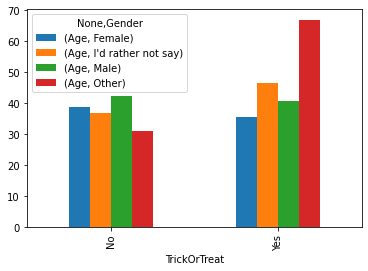

In [123]:
pd.pivot_table(pivotDF, index='TrickOrTreat', columns='Gender').plot(kind='bar')

#### Replace JOY, DESPAIR, MEH, and UNKNOWN with numerical values to get an overall sentiment.
JOY = 1  
DESPAIR = -1  
MEH, UNKNOWN = 0

In [125]:
pivotDF.replace('JOY', 1, inplace=True)
pivotDF.replace('DESPAIR', -1, inplace=True)
pivotDF.replace(['MEH', 'UNKNOWN'], 0, inplace=True)

In [127]:
# pivotDF.head(3)

,Timestamp,TrickOrTreat,Gender,Age,Country,Locale,[100 Grand Bar],[Anonymous brown globs that come in black and orange wrappers],[Any full-sized candy bar],[Black Jacks],...,[Three Musketeers],[Tolberone something or other],[Trail Mix],[Twix],"[Vials of pure high fructose corn syrup, for main-lining into your vein]",[Vicodin],[Whatchamacallit Bars],[White Bread],[Whole Wheat anything],[York Peppermint Patties]
0,2016-10-24 05:09:23.033,No,Male,22.0,Canada,Ontario,1,-1,1,0,...,1,1,-1,1,-1,1,-1,-1,-1,1
1,2016-10-24 05:09:54.798,No,Male,45.0,United States,il,0,0,1,1,...,1,1,0,1,-1,1,1,-1,-1,1
2,2016-10-24 05:13:06.734,No,Female,48.0,United States,Colorado,1,-1,1,0,...,1,1,-1,1,-1,-1,0,-1,-1,1


#### Get candy sentiment of Trick or Treaters vs non-Trick or Treaters:

In [130]:
pd.pivot_table(pivotDF, columns='TrickOrTreat', values=list(pivotDF.columns[6:]))

TrickOrTreat,No,Yes
[100 Grand Bar],0.371097,0.369565
[Anonymous brown globs that come in black and orange wrappers],-0.606601,-0.608696
[Any full-sized candy bar],0.822480,0.833333
[Black Jacks],-0.344335,-0.369565
[Blue M&M's],0.436218,0.434783
...,...,...
[Vicodin],0.046387,0.043478
[Whatchamacallit Bars],0.240856,0.253623
[White Bread],-0.764496,-0.688406
[Whole Wheat anything],-0.603925,-0.637681


#### Get candy sentiment by Gender:

In [131]:
pd.pivot_table(pivotDF, columns='Gender', values=list(pivotDF.columns[6:]))

Gender,Female,I'd rather not say,Male,Other
[100 Grand Bar],0.265854,0.321429,0.422642,0.470588
[Anonymous brown globs that come in black and orange wrappers],-0.629268,-0.428571,-0.601258,-0.529412
[Any full-sized candy bar],0.824390,0.642857,0.827673,0.941176
[Black Jacks],-0.363415,-0.214286,-0.343396,-0.235294
[Blue M&M's],0.439024,0.321429,0.440252,0.352941
...,...,...,...,...
[Vicodin],-0.068293,0.035714,0.101887,0.176471
[Whatchamacallit Bars],0.136585,0.107143,0.301887,0.176471
[White Bread],-0.712195,-0.607143,-0.787421,-0.647059
[Whole Wheat anything],-0.546341,-0.500000,-0.645283,-0.470588
